# Basic analysis for Sephora foundation reviews

- Overview
    - [About the dataset](#about)
    - [Missingness](#missing)
- Dataset characteristics
    - [Descriptive statistics](#descriptive)
    - [Rating overview](#rating_overview)
    - [Location overview](#location_overview)
    - [Brand overview](#brand_overview)
    - [Age overview](#age_overview)
    - [Membership status](#membership_status)
- [Foundation characteristics](#foundation_characteristics)
- [Incentivized reviews](#incentivized)



- [Conclusions](#conclusions)

In [87]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
reviews = pd.read_csv("./data/sephora_reviews_final.csv")

## Overview

<a id='about'></a>

### About the dataset:

In total, our dataset consists of 275,950 foundation reviews with 28 different columns. These columns include brand, name, product id, coverage, foundation, finish, formulation, normal skin, oily skin, combo skin, dry skin, SPF, username, rating, recommend, skin type, eye color, skin tone, skin concerns, age, beauty insider, price, first submission date, last submission date, location, incentivized review, review text, brand image url, and product image url. For our purposes, we will not need to analyze every columns, but we do have comprehensive information on user preferences and profiles (i.e. age, skin type, location, rating, recommendation) , as well as product information (coverage, finish, price).

In [267]:
reviews.sample(3)

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,SPF,user_name,rating,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url,clean_review_text,polarity,subjectivity
123062,bareMinerals,Matte Foundation Broad Spectrum SPF 15,P240604,Medium,Matte,Loose,True,True,True,True,True,gojules,5,NaN,NaN,brown,light,NaN,35to44,yes,29.0,2011-10-20 12:52:44,2011-10-20 13:00:07,fl,NaN,This is my favorite foundation. I started usin...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s192...,"[favorite, foundation, started, using, 6, mont...",0.500000,1.000000
24008,Estée Lauder,Double Wear Stay-in-Place Foundation,P378284,Full,Matte,Liquid,True,True,True,True,False,Josiemk,5,True,combination,brown,fair,blackheads,over54,NaN,42.0,2018-07-12 20:26:58,2018-10-09 16:25:24,NaN,NaN,"This foundation is awesome,, I'm so glad I gav...",/contentimages/brands/esteelauder/071613_Estee...,https://www.sephora.com/productimages/sku/s146...,"[foundation, awesome, im, glad, gave, 2, nd, s...",0.288776,0.456122
146728,bareMinerals,BarePRO™ Performance Wear Liquid Foundation Br...,P421001,Full,Matte,Liquid,True,True,True,True,True,ginabs,4,True,dry,brown,medium,aging,NaN,NaN,34.0,2018-09-07 14:04:19,2018-09-07 14:15:09,NaN,NaN,A little goes along way. If you like Bare Min...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s196...,"[little, goes, along, way, like, bare, mineral...",0.090714,0.494286


In [268]:
reviews.shape

(275950, 31)

In [269]:
#reviews.info()

<a id='missing'></a>

### Missingness

We should also try and get an idea of our data--what do we have and what are we missing?

We can see that we have most of the important information: brand, name/product id, rating, price, and review text, as well as some other secondary information.

Columns with missing data:
- **coverage**: 31.826780%
- **finish**: 32.198587%
- **formulation**: 44.085160%
- **user_name**: 1.065410%
- **recommended**: 70.390650%
- **skin_type**: 51.308933%
- **eye_color**: 35.678203%
- **skin_tone**: 33.739083%
- **skin_concerns**: 74.319623%
- **age**: 56.678384%
- **beauty_insider**: 59.779308%
- **location**: 58.768255%
- **incentivized_review**: 71.218337%

Columns with missing values have variable amounts of missingness, so we need to remember to take any analysis with these columns with a grain of salt. That being said, I think there is still valuable information that give us insight on how users are rate foundations.

In [265]:
reviews.columns[reviews.isna().sum(axis = 0) == 0]

Index(['brand', 'name', 'product_id', 'normal_skin', 'oily_skin', 'combo_skin',
       'dry_skin', 'SPF', 'rating', 'price', 'first_submission_date',
       'last_submission_date', 'review_text', 'brand_image_url',
       'product_image_url', 'clean_review_text', 'polarity', 'subjectivity'],
      dtype='object')

In [266]:
reviews.isna().sum(axis = 0)[reviews.isna().sum(axis = 0) > 0]/len(reviews)*100

coverage               31.826780
finish                 32.198587
formulation            44.085160
user_name               1.065410
recommended            70.390650
skin_type              51.308933
eye_color              35.678203
skin_tone              33.739083
skin_concerns          74.319623
age                    56.678384
beauty_insider         59.779308
location               58.768255
incentivized_review    71.218337
dtype: float64

<a id='descriptive'></a>

### Descriptive Statistics

On average, users gave foundations a rating of 4.12 with a standard deviation of 1.26. The 25th percentile tells us that most ratings are 4+ stars, indicating that we have a skewed distribution.

In [270]:
reviews[["rating"]].describe()

,rating
count,275950.000000
mean,4.123794
std,1.255406
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
reviews.describe(include = ["O"])

<a id='rating_overview'></a>

### Rating overview

In [ ]:
sns.countplot("rating", data = reviews)

<a id = "location_overview"></a>

### Location overview

Not a perfect fix, but we can clean up a bit of the text data for "location" to see where our reviewers/purchasers are coming from.

In [ ]:
reviews["location"] = reviews["location"].str.lower().str.replace('[^\w\s]','').str.strip()

Top 10 cities/locations

In [ ]:
reviews["location"].value_counts()[:10]

In [ ]:
plt.figure(figsize = (10,7))
sns.barplot(reviews["location"].value_counts()[:10].index, reviews["location"].value_counts()[:10])
plt.title("Reviews by location")
plt.xlabel("Location")
plt.ylabel("Number of reviews")
plt.xticks(rotation = 90)

We can look at the average rating across the top 10 cities. Doesn't seem to give us any interesting information.

In [ ]:
top10cities_reviews = reviews[reviews["location"].isin(reviews["location"].value_counts()[:10].index)]

In [ ]:
top10cities_reviews.groupby(["location"]).agg({"rating": "mean"})

<a id='brand_overview'></a>

### Brand overview

We have 217 distinct foundations, coming from 63 different brands -- 14 for you Clinique, you go Clinique!

In [ ]:
reviews[["brand", "name"]].drop_duplicates()[["brand"]].describe()

It does not surprise me that La Mer has a \\$120 foundation. It does surprise me that Giorgio Armani does, but I guess it's also a high-end brand. Sephora's in-house brand is the cheapest, which is unsurprising. One thing that this dataset failed to collect is the product size (i.e. fl oz.). Most foundations are 1 fl. oz., but there is some variability that could make a foundation more (or less expensive) than expected.

In [ ]:
reviews[["brand", "name", "price"]].drop_duplicates().sort_values(by="price", ascending = False)

The average foundation price is \\$44.71, the cheapest being \\$18 and the priciest being \\$120, with a standard deviation of \\$15.02. Again, the foundation prices don't surprise me much since these are pretty consistent with what we would find at Sephora, which houses mainly mid-range to high-end brands.

In [ ]:
reviews[["brand", "name", "price"]].drop_duplicates().describe()

In [ ]:
reviews[["brand", "name", "price"]].drop_duplicates().median()

In [ ]:
avg_price = reviews[["brand", "name", "price"]].drop_duplicates()["price"].mean()

Histogram of foundation prices found at Sephora

In [ ]:
plt.figure(figsize = (15, 10))
sns.distplot(reviews[["brand", "name", "price"]].drop_duplicates()["price"], kde = False)
plt.title("Foundation prices")
plt.xlabel("Price")
plt.ylabel("Number of products")
plt.xticks(rotation = 90)

It's pretty clear that there are some outliers, so let's use median price instead.

In [ ]:
median_price = reviews[["brand", "name", "price"]].drop_duplicates()["price"].median()

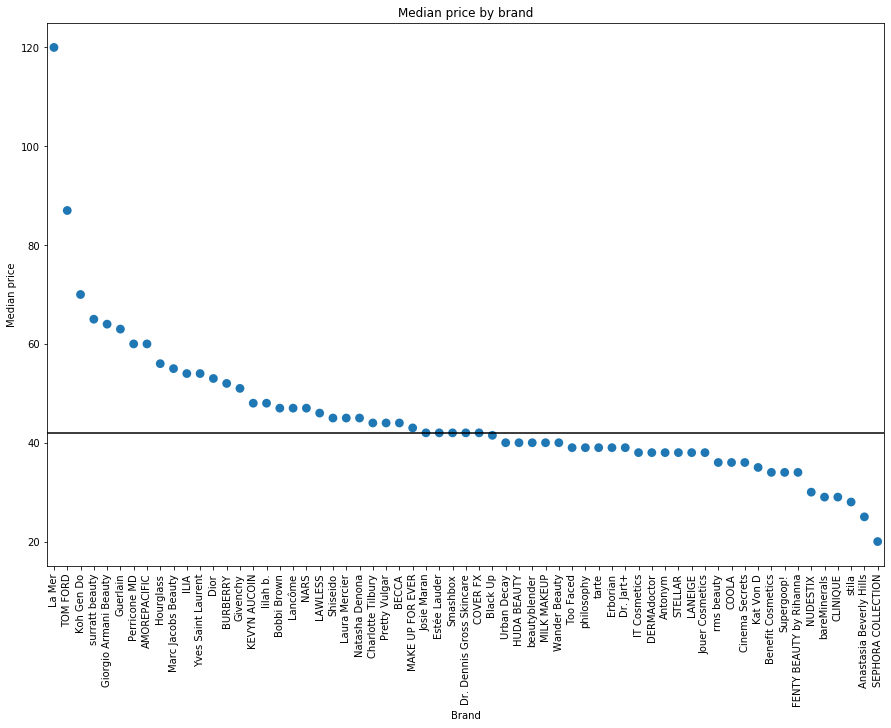

In [183]:
plt.figure(figsize = (15,10))
sns.pointplot(x = "brand", y = "price", data = reviews, estimator = np.median, order = reviews.groupby("brand").agg({"price": "median"}).reset_index().sort_values(by = "price", ascending = False)["brand"], join = False, ci = None)
plt.title("Median price by brand")
plt.xlabel("Brand")
plt.ylabel("Median price")
plt.xticks(rotation = 90)
plt.axhline(y=median_price, color='black', linestyle='-')

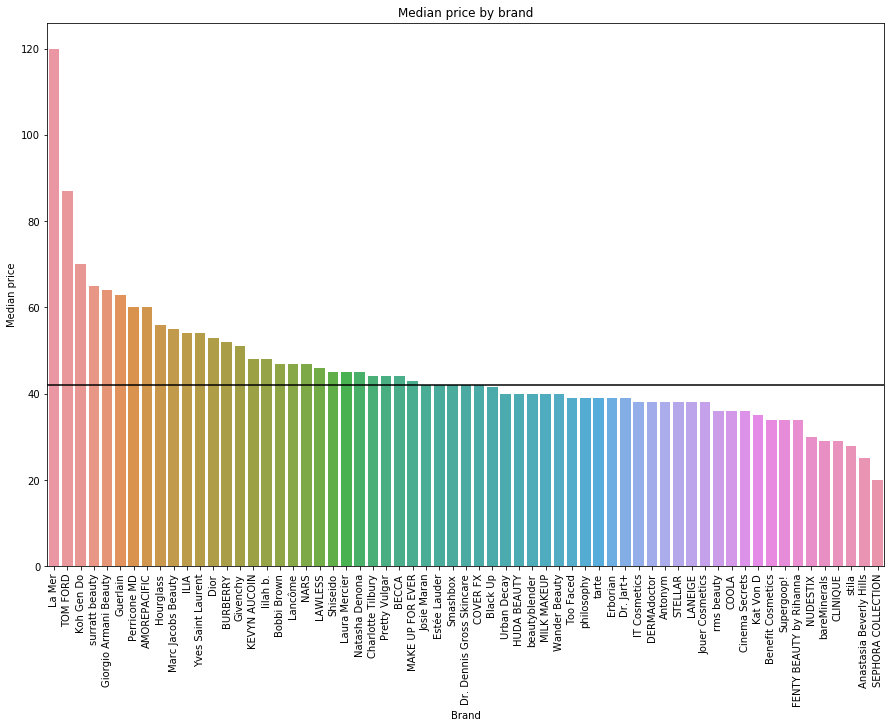

In [124]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby(["brand"]).agg({"price": "median"}).sort_values(by = "price", ascending = False).index.to_series(), y = reviews.groupby(["brand"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"], ci = None)
plt.title("Median price by brand")
plt.xlabel("Brand")
plt.ylabel("Median price")
plt.xticks(rotation = 90)
plt.axhline(y=median_price, color='black', linestyle='-')

33 brands with above or at median price

In [ ]:
reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] >= median_price].index.to_list()

In [ ]:
len(reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] >= median_price])

30 brands with below-median prices.

In [ ]:
reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] < median_price].index.to_list()

In [ ]:
len(reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] < median_price])

Median price by product. Pretty granular info, but we can see that most foundations stay close to median price.

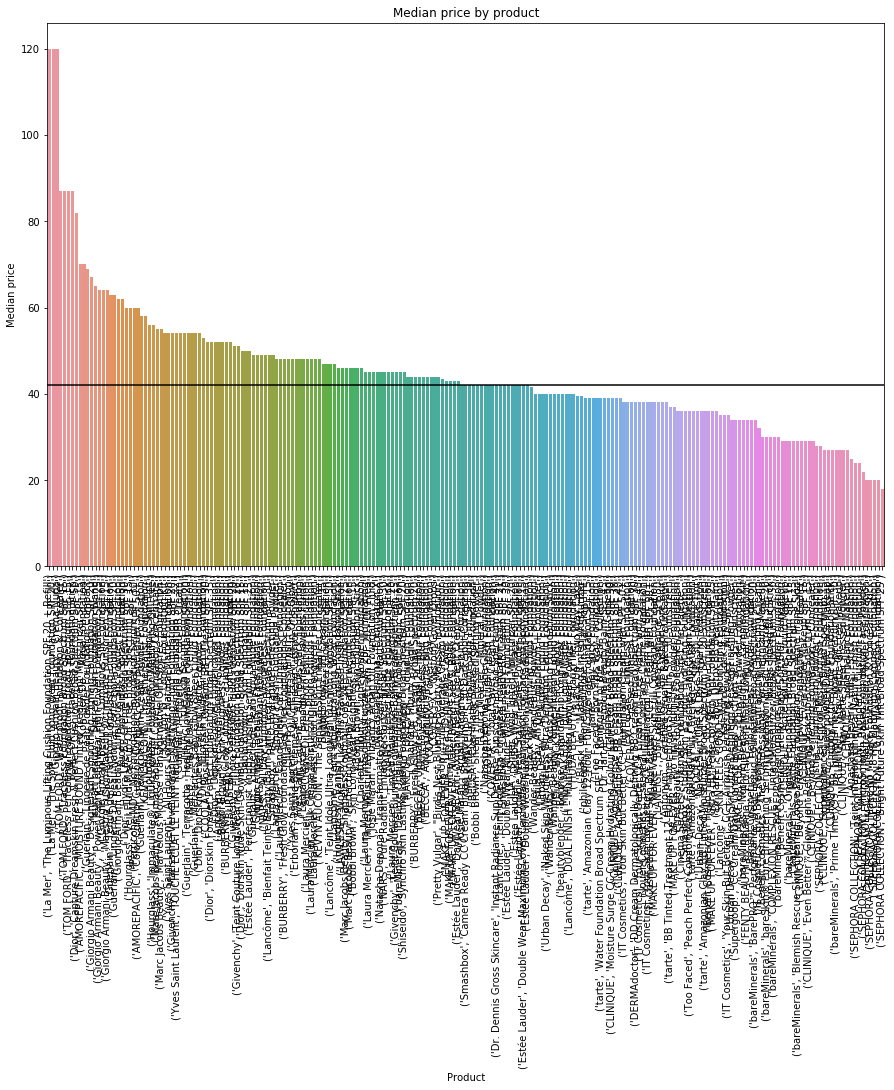

In [181]:
# plt.figure(figsize = (15,10))
# sns.barplot(x = reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False).index.to_series(), y = reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"], ci = None)
# plt.title("Median price by product")
# plt.xlabel("Product")
# plt.ylabel("Median price")
# plt.xticks(rotation = 90)
# plt.axhline(y=median_price, color='black', linestyle='-')

107 products above median price

In [ ]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] > median_price])

In [ ]:
len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] > median_price]))

92 products below median price

In [ ]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] < median_price])

In [ ]:
len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] < median_price]))

18 products at median price

In [ ]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] == median_price])

In [ ]:
len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] == median_price]))

Average rating by brand.

In [ ]:
avg_rating = reviews["rating"].mean()

In [185]:
#reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)

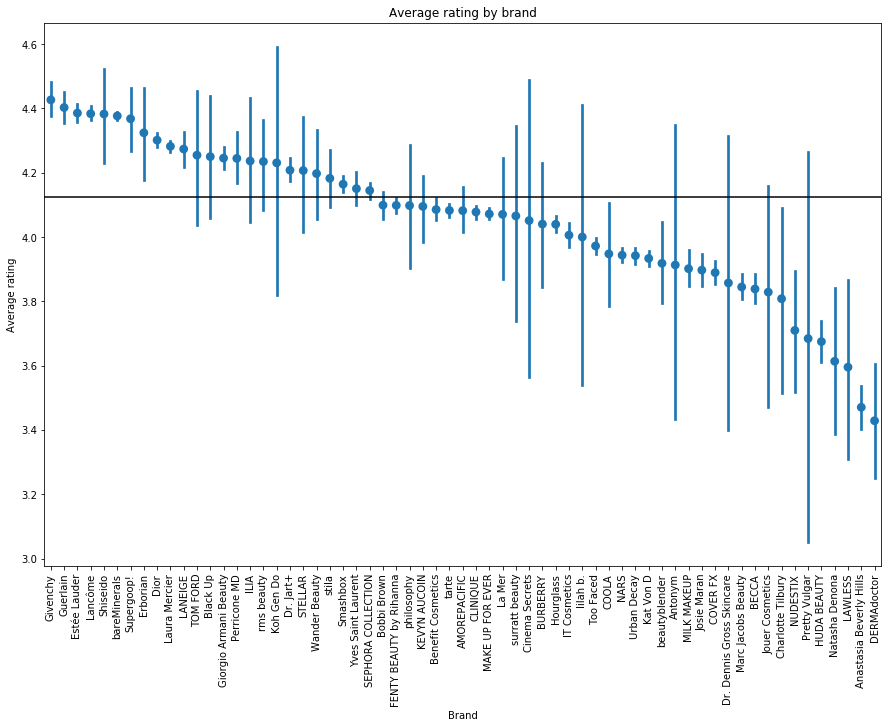

In [165]:
plt.figure(figsize = (15,10))
sns.pointplot(x = "brand", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["brand"], join = False)
plt.title("Average rating by brand")
plt.xlabel("Brand")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

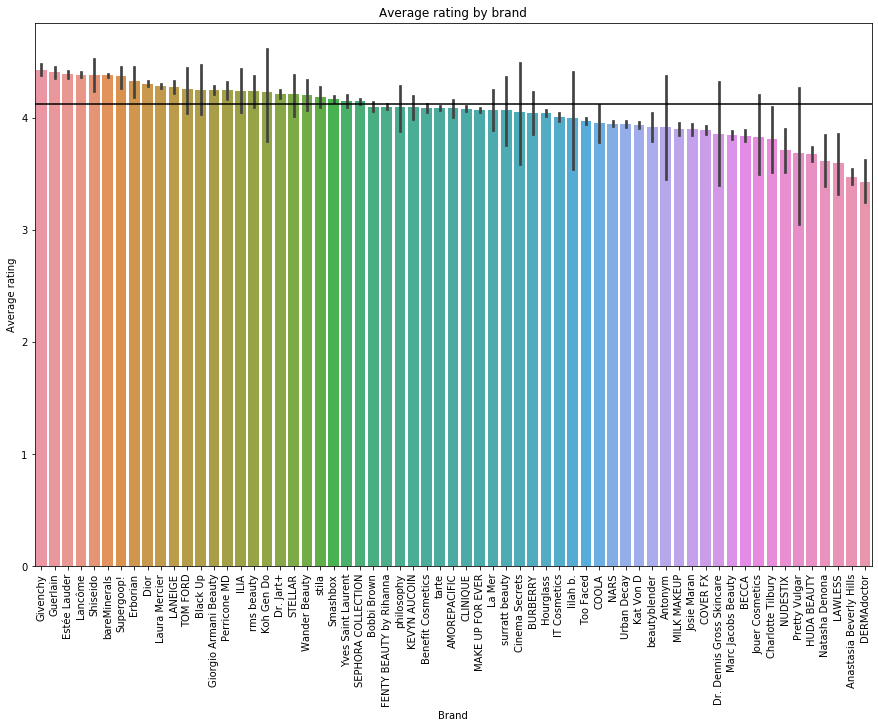

In [164]:
plt.figure(figsize = (15,10))
sns.barplot(x = "brand", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["brand"])
plt.title("Average rating by brand")
plt.xlabel("Brand")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text xticklabel objects>)

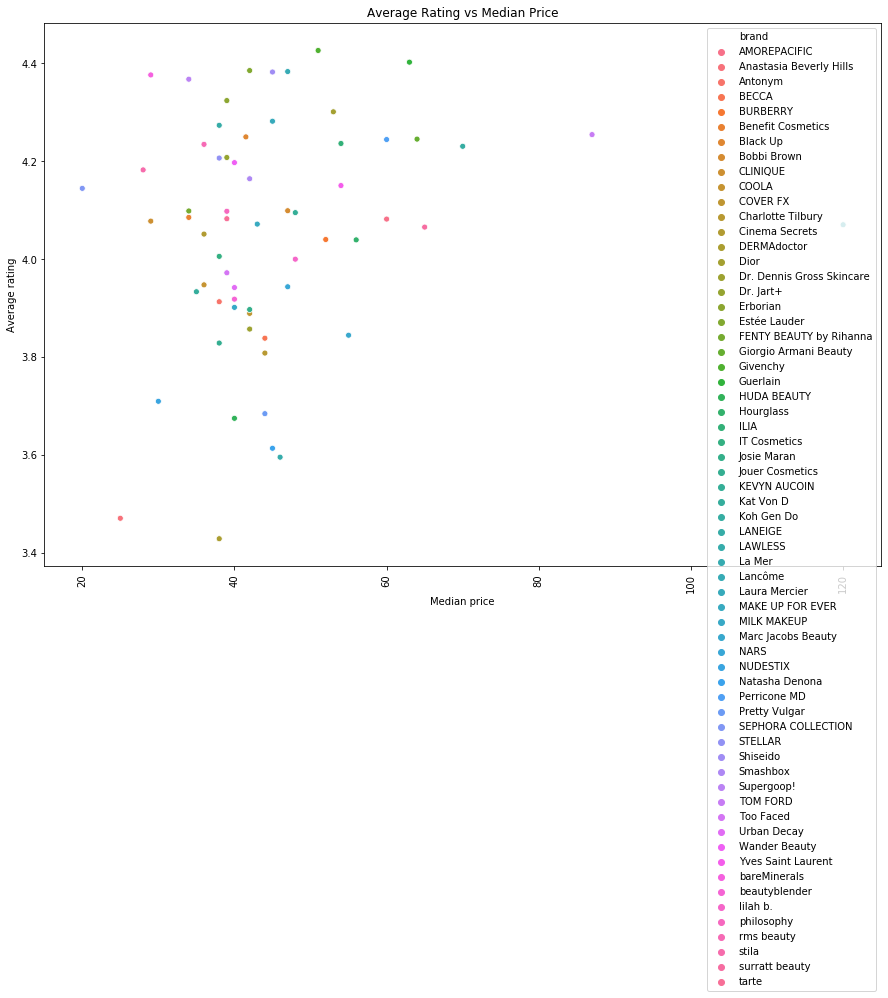

In [186]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = "price", y = "rating", hue = reviews.groupby("brand").agg({"price": "median", "rating": "mean"}).index, data = reviews.groupby("brand").agg({"price": "median", "rating": "mean"}))
plt.title("Average Rating vs Median Price")
plt.xlabel("Median price")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

We can also look at how well each individual product stacks up against the average.

In [172]:
# plt.figure(figsize = (15,10))
# sns.barplot(x = reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False).index.to_series(), y = reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"], ci = None)
# plt.title("Average rating by product")
# plt.xlabel("Product")
# plt.ylabel("Average rating")
# plt.xticks(rotation = 90)
# plt.axhline(y=avg_rating, color='black', linestyle='-')

In [171]:
reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)

,,rating
brand,name,
lilah b.,Marvelous Matte™ Crème Foundation,4.666667
bareMinerals,Original Foundation Broad Spectrum SPF 15,4.612741
Bobbi Brown,Sheer Finish Pressed Setting Powder,4.561086
Guerlain,Lingerie De Peau Natural Perfection Foundation SPF 20,4.500978
MAKE UP FOR EVER,Duo Mat Powder Foundation,4.496236
Givenchy,Teint Couture Long-Wearing Fluid Foundation Broad Spectrum SPF 20,4.473684
Laura Mercier,Mineral Powder,4.452290
Givenchy,Teint Couture Blurring Foundation Balm Broad Spectrum 15,4.444444
CLINIQUE,Even Better™ Glow Light Reflecting Makeup Broad Spectrum SPF 15,4.441176


98 products with higher-than-average ratings

In [ ]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating])

In [ ]:
len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating]))

10 highest-performing foundations

In [ ]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating]).head(10)

119 products with lower-than-average ratings

In [ ]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating])

In [ ]:
len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating]))

10 lowest-performing foundations

In [ ]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating]).tail(10)

In [ ]:
#reviews.groupby(["brand", "name"]).agg({"rating": ["count", "mean"]}).xs("rating", axis = 1, drop_level = True).sort_values(by = "mean", ascending = False)

In [ ]:
#reviews.groupby(["brand", "name"]).agg({"rating": ["count", "mean"]}).xs("rating", axis = 1, drop_level = True).sort_values(by = "count", ascending = False)

<a id = "age_overview"></a>

### Age overview

Looks like reviews go up with age.

In [ ]:
reviews["age"].isna().sum()/len(reviews)

In [187]:
reviews.groupby("age").agg({"rating": ["count", "mean"]})

rating          
        count      mean
age                    
13to17   5039  4.095059
18to24  34406  4.176917
25to34  42920  4.247018
35to44  18338  4.312902
45to54  11510  4.429192
over54   7333  4.433520

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

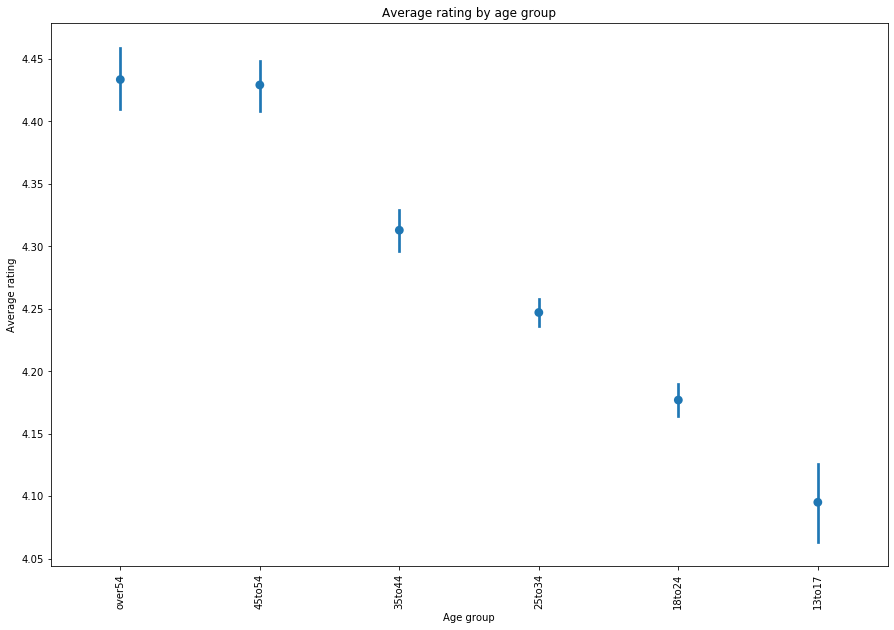

In [191]:
plt.figure(figsize = (15,10))
sns.pointplot(x = "age", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("age").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["age"], join = False)
plt.title("Average rating by age group")
plt.xlabel("Age group")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

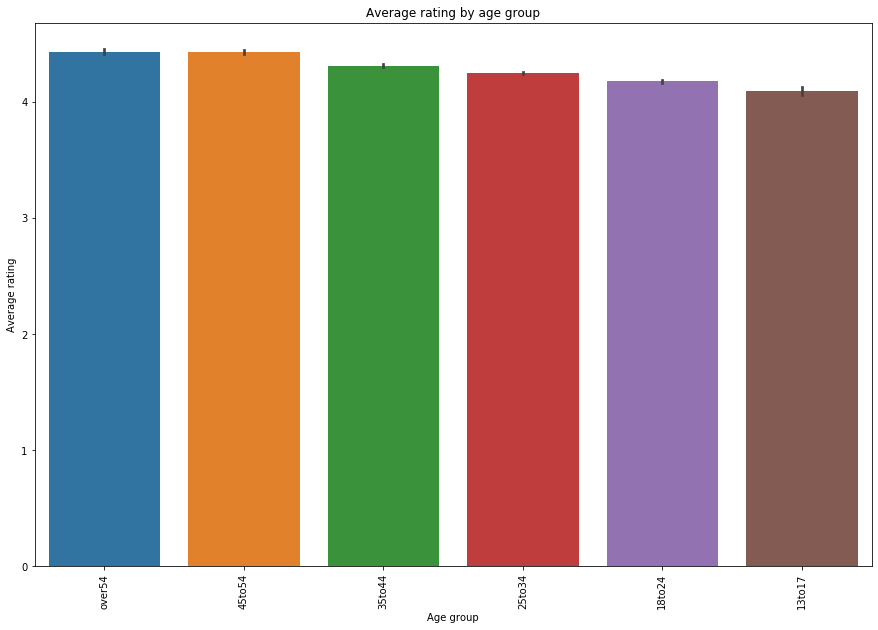

In [192]:
plt.figure(figsize = (15,10))
sns.barplot(x = "age", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("age").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["age"])
plt.title("Average rating by age group")
plt.xlabel("Age group")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

<a id = "membership_status"></a>

### Membership status

This is interesting! Sephora tiers are: (1) None (2) Beauty Insider (3) VIB (4) VIB Rouge. This makes sense to me since more frequent shoppers will probably be harsher with their reviews -- we have higher expectations!

In [ ]:
reviews["beauty_insider"].isna().sum()/len(reviews)

In [ ]:
reviews.groupby("beauty_insider").agg({"rating": "mean"})

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

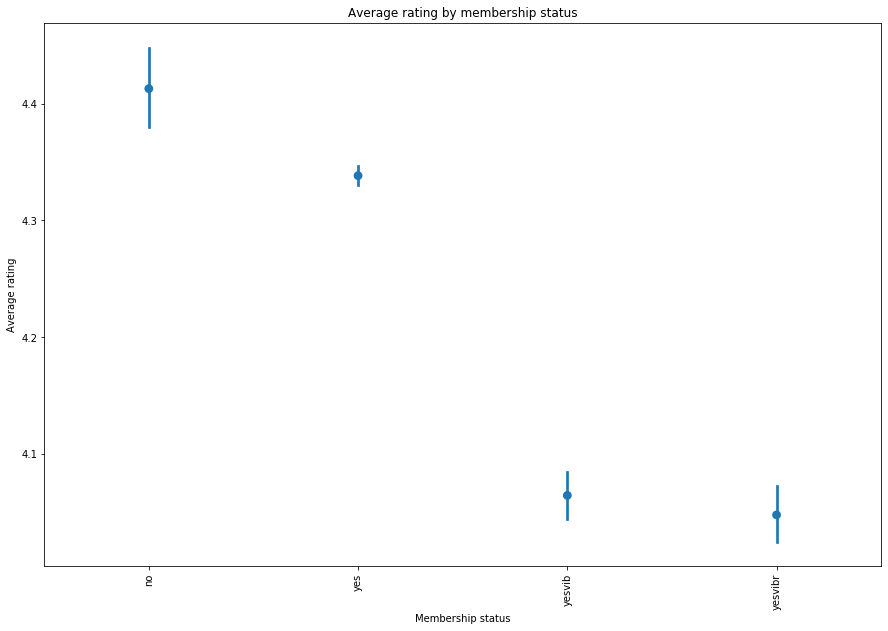

In [195]:
plt.figure(figsize = (15,10))
sns.pointplot(x = "beauty_insider", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("beauty_insider").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["beauty_insider"], join = False)
plt.title("Average rating by membership status")
plt.xlabel("Membership status")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

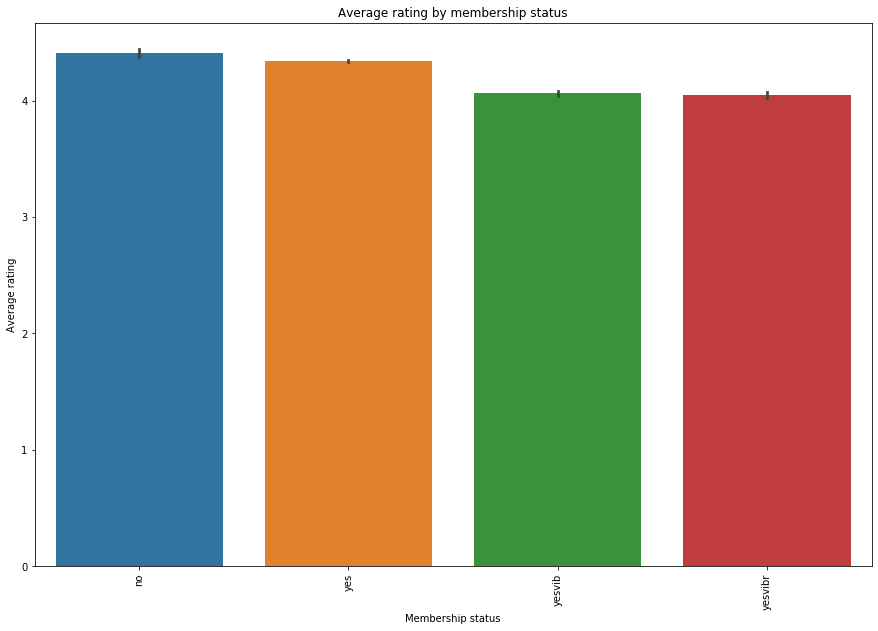

In [196]:
plt.figure(figsize = (15,10))
sns.barplot(x = "beauty_insider", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("beauty_insider").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["beauty_insider"])
plt.title("Average rating by membership status")
plt.xlabel("Membership status")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

<a id = "foundation_characteristics"></a>

## Foundation characteristics

We can look at the coverage, finish, formulation, and SPF.

In [ ]:
reviews["coverage"].isna().sum()/len(reviews)

In [209]:
reviews.groupby("coverage").agg({"rating": ["count", "mean"]})

rating          
          count      mean
coverage                 
Full      74856  3.977958
Light     16985  3.998822
Medium    96283  4.245962

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

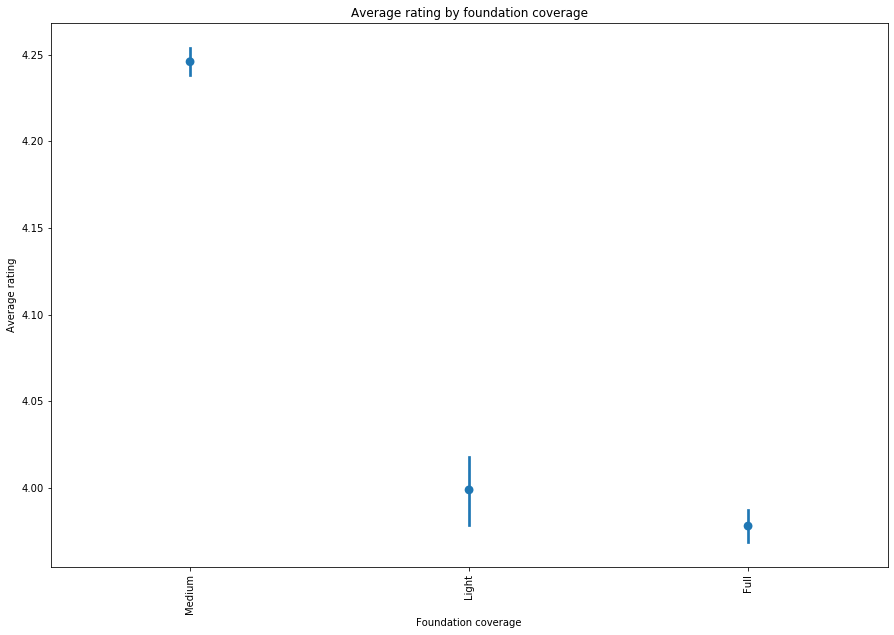

In [198]:
plt.figure(figsize = (15,10))
sns.pointplot(x = "coverage", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("coverage").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["coverage"], join = False)
plt.title("Average rating by foundation coverage")
plt.xlabel("Foundation coverage")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

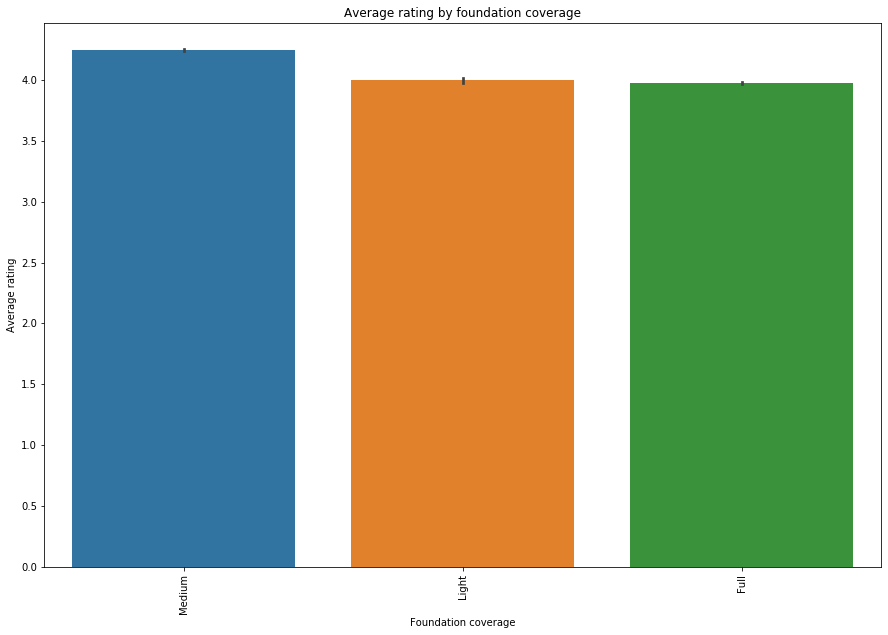

In [234]:
plt.figure(figsize = (15,10))
sns.barplot(x = "coverage", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("coverage").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["coverage"])
plt.title("Average rating by foundation coverage")
plt.xlabel("Foundation coverage")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

In [219]:
reviews[["brand", "name", "coverage", "price"]].dropna().drop_duplicates().groupby("coverage").agg({"price": "mean"})

,price
coverage,
Full,48.250000
Light,39.894737
Medium,42.068182


In [ ]:
reviews["finish"].isna().sum()/len(reviews)

In [ ]:
reviews.groupby("finish").agg({"rating": ["count", "mean"]})

Most light-coverage foundations tend to have a natural finish, while most full-coverage foundations have a matte finish. This also isn't surprising, since radiant/natural foundations tend to not be as long-lasting. I am surprised that there aren't more reviews for radiant foundations, especially in the light/medium-coverage foundations, since dewy looks are trending. I don't know how old this dataset is, so it may be different today.

In [ ]:
(reviews["coverage"].isna() | reviews["finish"].isna()).sum()/len(reviews)

In [ ]:
reviews.groupby(["coverage", "finish"]).agg({"rating": ["count", "mean"]})

In [ ]:
sns.catplot(x = "finish", y = "rating", col = "coverage", data = reviews)

In [ ]:
reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"}).unstack()

In [ ]:
#sns.catplot(reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"}).unstack().reset_index(), hue = ")

In [ ]:
reviews.groupby(["coverage", "finish"]).agg({"rating": "mean"}).unstack().xs("rating", axis = 1, drop_level = True)

People like their SPF! But just a reminder that foundation/beauty products do not contain enough SPF so we should be wearing additional SPF :)

In [ ]:
reviews.groupby("SPF").agg({"rating": "mean"})

In [ ]:
reviews.groupby(["age", "coverage"]).agg({"rating": ["count", "mean"]})

In [ ]:
reviews.groupby(["age", "finish"]).agg({"rating": ["count", "mean"]})

Formulation

In [ ]:
reviews["formulation"].isna().sum()/len(reviews)

In [ ]:
reviews["formulation"].value_counts()

Checked online and the foundation "LiquidStick" is actually a liquid, so I just renamed it.

In [ ]:
reviews.loc[reviews["formulation"] == "LiquidStick", "formulation"] = "Liquid"

In [ ]:
reviews["formulation"].value_counts()

Surprisingly, loose foundations have the highest performance. Maybe I should go check out bareMinerals.

In [68]:
reviews.groupby("formulation").agg({"rating": "mean"})

,rating
formulation,
Cream,4.199648
Liquid,4.027122
Loose,4.546884
Pressed,4.351373
Stick,4.026189


In [69]:
reviews[reviews["formulation"] == "Loose"][["brand", "name"]].drop_duplicates()

,brand,name
43998,bareMinerals,Original Foundation Broad Spectrum SPF 15
119844,bareMinerals,Matte Foundation Broad Spectrum SPF 15


Skin type doesn't tell us much

In [70]:
reviews["skin_type"].isna().sum()/len(reviews)

0.5130893277767712

In [71]:
reviews.groupby(["skin_type"]).agg({"rating": ["count", "mean"]})

rating          
             count      mean
skin_type                   
combination  70739  4.095520
dry          21060  4.058025
normal       17568  4.121699
oily         24996  4.049488

Skin tone

In [72]:
reviews["skin_tone"].value_counts()

light        55695
medium       47626
fair         38879
olive        16050
deep          7735
tan           6385
porcelain     6190
dark          3687
ebony          600
Name: skin_tone, dtype: int64

In [73]:
reviews.groupby("skin_tone").agg({"rating": "mean"})

,rating
skin_tone,
dark,4.288310
deep,4.297091
ebony,4.401667
fair,4.077651
light,4.185385
medium,4.274829
olive,4.263053
porcelain,3.758805
tan,4.215035


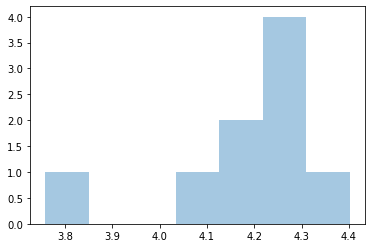

In [74]:
sns.distplot(reviews.groupby("skin_tone").agg({"rating": "mean"}), kde = False)

In [75]:
reviews[reviews["skin_tone"] == "porcelain"].groupby(["brand", "name"]).agg({"rating": ["count","mean"]})["rating"].sort_values(by = "count", ascending = False)

count  \
brand                   name                                                        
FENTY BEAUTY by Rihanna Pro Filt'r Soft Matte Longwear Foundation             877   
Kat Von D               Lock-It Foundation                                    406   
Too Faced               Born This Way Foundation                              257   
                        Peach Perfect Comfort Matte Foundation – Peache...    242   
MAKE UP FOR EVER        Ultra HD Invisible Cover Foundation                   213   
...                                                                           ...   
Erborian                Liquid BB Crème Au Ginseng Cushion Compact              1   
Estée Lauder            Double Wear Nude Cushion Stick Radiant Foundation       1   
Bobbi Brown             Sheer Finish Pressed Setting Powder                     1   
Marc Jacobs Beauty      Marvelous Mousse Transformative OilFree Founda...      1   
MAKE UP FOR EVER        Liquid Lift Foundation                                  1   

                                                                                mean  
brand                   name                                                          
FENTY BEAUTY by Rihanna Pro Filt'r Soft Matte Longwear Foundation           3.393387  
Kat Von D               Lock-It Foundation                                  3.665025  
Too Faced               Born This Way Foundation                            3.813230  
                        Peach Perfect Comfort Matte Foundation – Peache...  4.086777  
MAKE UP FOR EVER        Ultra HD Invisible Cover Foundation                 3.830986  
...                                                                              ...  
Erborian                Liquid BB Crème Au Ginseng Cushion Compact          5.000000  
Estée Lauder            Double Wear Nude Cushion Stick Radiant Foundation   3.000000  
Bobbi Brown             Sheer Finish Pressed Setting Powder                 2.000000  
Marc Jacobs Beauty      Marvelous Mousse Transformative OilFree Founda...  5.000000  
MAKE UP FOR EVER        Liquid Lift Foundation                              1.000000  

[187 rows x 2 columns]

In [76]:
reviews[reviews["skin_tone"] == "ebony"].groupby(["brand", "name"]).agg({"rating": ["count","mean"]})["rating"].sort_values(by = "count", ascending = False)

,,count,mean
brand,name,,
FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,163,4.705521
MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,31,4.290323
Kat Von D,Lock-It Foundation,27,4.407407
BECCA,Ultimate Coverage 24-Hour Foundation,26,4.307692
NARS,Natural Radiant Longwear Foundation,23,3.913043
Marc Jacobs Beauty,Shameless Youthful-Look 24H Foundation SPF 25,19,4.421053
COVER FX,Power Play Foundation,16,4.500000
Lancôme,Teint Idole Ultra Long Wear Foundation,16,5.000000
Too Faced,Born This Way Foundation,15,4.466667


<a id = "incentivized"></a>

### Incentivized Reviews

Let's make the VERY strong assumption that customers are being honest about whether they are leaving an incentivized review (i.e. they received the product for free to leave an honest review).

In [77]:
reviews["incentivized_review"].value_counts()

False    75319
True      4104
Name: incentivized_review, dtype: int64

In [78]:
reviews.groupby("incentivized_review").agg({"rating": "mean"})

,rating
incentivized_review,
False,3.902256
True,4.206871


In [79]:
unbiased_reviews = reviews[reviews["incentivized_review"] == False]
biased_reviews = reviews[reviews["incentivized_review"] == True]

In [80]:
unbiased_reviews.groupby("age").agg({"rating": ["count", "mean"]})

rating          
        count      mean
age                    
13to17   1245  3.795181
18to24   9535  3.930572
25to34   8914  3.986201
35to44   2749  4.052383
45to54   1587  4.243856
over54    868  4.243088

In [82]:
biased_reviews.groupby("age").agg({"rating": ["count", "mean"]})

rating          
        count      mean
age                    
13to17     80  3.912500
18to24   1438  4.269124
25to34   1612  4.240695
35to44    399  4.157895
45to54    139  4.352518
over54     52  3.923077

In [231]:
reviews.groupby(["incentivized_review", "age"]).agg({"rating": ["count", "mean"]})

rating          
                            count      mean
incentivized_review age                    
False               13to17   1245  3.795181
                    18to24   9535  3.930572
                    25to34   8914  3.986201
                    35to44   2749  4.052383
                    45to54   1587  4.243856
                    over54    868  4.243088
True                13to17     80  3.912500
                    18to24   1438  4.269124
                    25to34   1612  4.240695
                    35to44    399  4.157895
                    45to54    139  4.352518
                    over54     52  3.923077

Text(0, 0.5, 'Average rating')

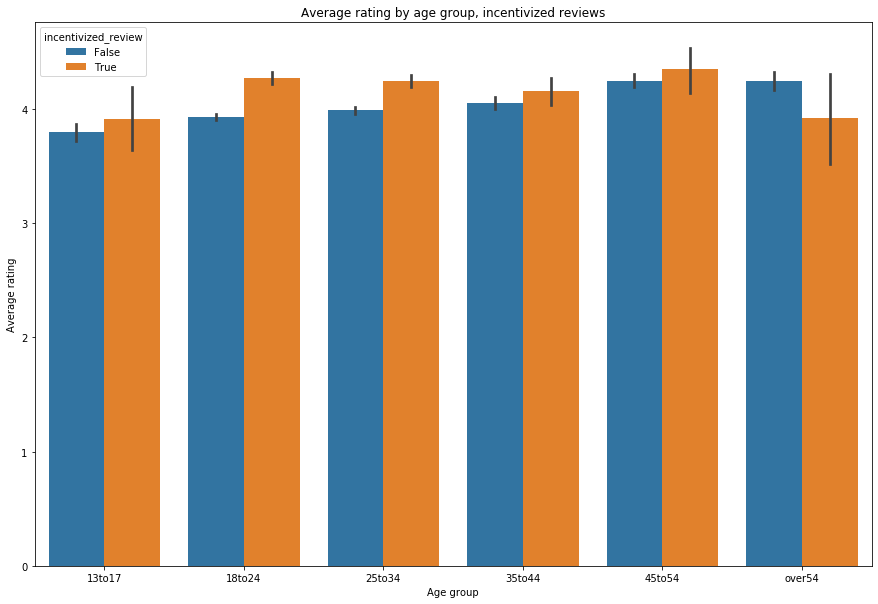

In [258]:
plt.figure(figsize = (15,10))
sns.barplot(x = "age", y = "rating", hue = "incentivized_review", data = reviews, estimator = np.mean, order = sorted(reviews["age"].dropna().unique()))
plt.title("Average rating by age group, incentivized reviews")
plt.xlabel("Age group")
plt.ylabel("Average rating")

Text(0, 0.5, 'Number of users')

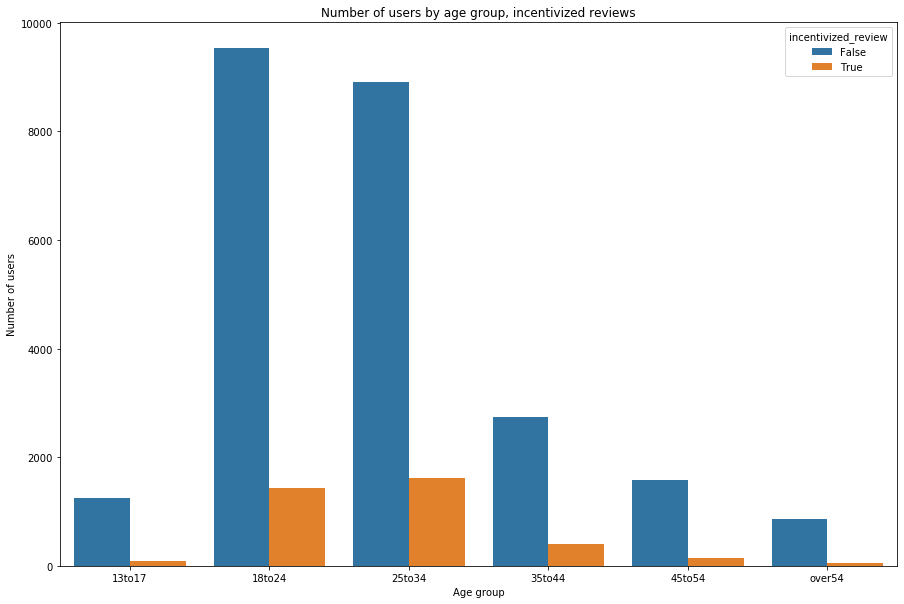

In [264]:
plt.figure(figsize = (15,10))
sns.countplot(x = "age", hue = "incentivized_review", data = reviews, order = sorted(reviews["age"].dropna().unique()))
plt.title("Number of users by age group, incentivized reviews")
plt.xlabel("Age group")
plt.ylabel("Number of users")

In [84]:
reviews.groupby(["age", "incentivized_review"]).agg({"rating": ["count", "mean"]})

rating          
                            count      mean
age    incentivized_review                 
13to17 False                 1245  3.795181
       True                    80  3.912500
18to24 False                 9535  3.930572
       True                  1438  4.269124
25to34 False                 8914  3.986201
       True                  1612  4.240695
35to44 False                 2749  4.052383
       True                   399  4.157895
45to54 False                 1587  4.243856
       True                   139  4.352518
over54 False                  868  4.243088
       True                    52  3.923077

In [259]:
#sns.catplot(x = "age", y = "incentivized_review", col = "rating", kind = "bar", stacked = True, data = reviews, order = sorted(reviews["age"].dropna().unique()))

In [260]:
reviews.groupby(["beauty_insider", "incentivized_review"]).size()

beauty_insider  incentivized_review
no              False                   498
                True                    189
yes             False                  9412
                True                   1860
yesvib          False                  8277
                True                    941
yesvibr         False                  6955
                True                    742
dtype: int64

In [262]:
reviews[reviews["incentivized_review"].notna()].groupby("beauty_insider").size()

beauty_insider
no           687
yes        11272
yesvib      9218
yesvibr     7697
dtype: int64

Proportion of incentivized vs non-incentivized review by BI status

In [261]:
reviews.groupby(["beauty_insider", "incentivized_review"]).size()/reviews[reviews["incentivized_review"].notna()].groupby("beauty_insider").size()

beauty_insider  incentivized_review
no              False                  0.724891
                True                   0.275109
yes             False                  0.834989
                True                   0.165011
yesvib          False                  0.897917
                True                   0.102083
yesvibr         False                  0.903599
                True                   0.096401
dtype: float64

## Reviews

Clean up review text

In [92]:
reviews["clean_review_text"] = deepcopy(reviews["review_text"])

In [93]:
reviews["clean_review_text"] = reviews["clean_review_text"].str.lower().str.replace('[^\w\s]','').str.strip()

Tokenize

In [94]:
tokenizer = RegexpTokenizer(r"\w+")

In [95]:
reviews["clean_review_text"] = reviews["clean_review_text"].apply(lambda text: tokenizer.tokenize(text))

Removing stopwords

In [96]:
stop = set(stopwords.words("english"))

In [97]:
reviews["clean_review_text"] = reviews["clean_review_text"].apply(lambda w: [w for w in w if w not in stop])

In [98]:
reviews["polarity"] = reviews["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [99]:
reviews["subjectivity"] = reviews["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [100]:
reviews.groupby("incentivized_review").agg({"polarity": "mean", "subjectivity": "mean"})

,polarity,subjectivity
incentivized_review,,
False,0.253820,0.578058
True,0.279683,0.587841


In [101]:
#reviews["polarity"].hist()

In [102]:
#reviews["subjectivity"].hist()

In [103]:
reviews.groupby("age").agg({"polarity": "mean", "subjectivity": "mean"})

,polarity,subjectivity
age,,
13to17,0.270910,0.579611
18to24,0.268073,0.573180
25to34,0.281386,0.567883
35to44,0.296865,0.562901
45to54,0.313253,0.558471
over54,0.314458,0.560084


In [104]:
reviews.groupby(["brand", "name"]).agg({"polarity": "mean", "subjectivity": "mean"}).sort_values(by = "polarity", ascending = False)

,,polarity,subjectivity
brand,name,,
Benefit Cosmetics,’Hello Flawless!’ Powder Foundation,0.351054,0.592026
MAKE UP FOR EVER,Duo Mat Powder Foundation,0.349287,0.574108
Givenchy,Matissime Velvet Radiant Mattifying Fluid Foundation SPF 20,0.340246,0.598841
SEPHORA COLLECTION,Matte Perfection Powder Foundation,0.338737,0.576223
LANEIGE,BB Cushion Hydra Radiance SPF 50,0.334702,0.618898
Givenchy,Photo’Perfexion Fluid Foundation SPF 20,0.334457,0.592626
Wander Beauty,Nude Illusion Liquid Foundation,0.333221,0.585922
Lancôme,SKIN FEELS GOOD Skin Nourishing Foundation,0.331189,0.620806
SEPHORA COLLECTION,MicroSmooth Baked Foundation Face Powder,0.328274,0.578535


In [105]:
reviews[reviews["polarity"] == reviews["polarity"].max()]

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,SPF,user_name,rating,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url,clean_review_text,polarity,subjectivity
36,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,BabyDoll143,5,True,combination,brown,dark,cellulite,NaN,NaN,34.0,2017-12-21 23:37:46,2018-12-06 23:23:08,NaN,NaN,Matches skin perfectly,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[matches, skin, perfectly]",1.0,1.000000
90,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,gigipink27,5,True,combination,brown,ebony,blackheads,NaN,NaN,34.0,2018-07-09 18:33:45,2018-11-09 18:31:03,NaN,NaN,Amazing!!! Matches perfectly,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[amazing, matches, perfectly]",1.0,0.950000
196,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,shiela1,5,True,oily,brown,medium,acne,NaN,NaN,34.0,2018-07-10 06:25:48,2018-07-10 06:30:01,NaN,NaN,BEST FOUNDATION I’VE TRIED and buildable cover...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[best, foundation, ive, tried, buildable, cove...",1.0,0.300000
339,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,bimshire,5,True,normal,brown,dark,darkCircles,NaN,NaN,34.0,2018-01-14 01:01:14,2018-01-14 01:15:02,NaN,NaN,Looks like skin! Flawless ultra lightweight co...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[looks, like, skin, flawless, ultra, lightweig...",1.0,0.650000
385,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Maqadoo,5,True,combination,hazel,light,acne,NaN,NaN,34.0,2017-10-22 23:36:39,2017-10-22 23:45:03,NaN,NaN,Best foundation I’ve ever used!!! Blends to pe...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[best, foundation, ive, ever, used, blends, pe...",1.0,0.650000
984,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,DellaV,3,True,combination,brown,dark,acne,NaN,NaN,34.0,2017-09-16 21:43:33,2017-09-16 21:45:08,NaN,NaN,I am still on the journey to find a foundation...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[still, journey, find, foundation, perfect, sh...",1.0,1.000000
1059,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,amandakoe,5,True,combination,green,medium,redness,NaN,NaN,34.0,2017-09-22 21:56:43,2017-09-22 22:00:04,NaN,NaN,"Loved this foundation, watch my video on youtu...",/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[loved, foundation, watch, video, youtube, htt...",1.0,0.800000
1128,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,LaDae,5,True,oily,brown,deep,acne,18to24,NaN,34.0,2018-09-14 20:20:16,2018-11-24 02:44:29,NaN,NaN,LOVE!!!!! I have acne prone skin and it did N...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[love, acne, prone, skin, cause, skin, break]",1.0,0.600000
1186,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,nand0,5,True,NaN,NaN,NaN,NaN,NaN,NaN,34.0,2017-09-08 21:13:21,2017-09-08 21:15:05,NaN,NaN,Aw

In [106]:
reviews.loc[reviews["polarity"].idxmin()]

brand                                              FENTY BEAUTY by Rihanna
name                             Pro Filt'r Soft Matte Longwear Foundation
product_id                                                       P87985432
coverage                                                            Medium
finish                                                               Matte
formulation                                                         Liquid
normal_skin                                                           True
oily_skin                                                             True
combo_skin                                                            True
dry_skin                                                              True
SPF                                                                  False
user_name                                                   AlexandraGoold
rating                                                                   1
recommended              

In [107]:
reviews.groupby("recommended").agg({"rating": "mean"})

,rating
recommended,
False,1.989165
True,4.623886


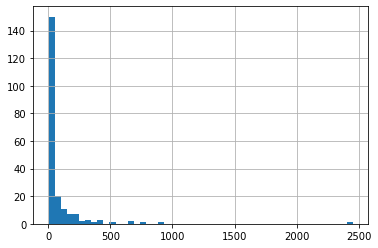

In [108]:
reviews[reviews["recommended"] == False]["name"].value_counts().hist(bins = 50)

In [109]:
reviews[reviews["recommended"] == False]["name"].value_counts()[:10]

Pro Filt'r Soft Matte Longwear Foundation                                2454
Lock-It Foundation                                                        901
Natural Radiant Longwear Foundation                                       738
#FauxFilter Foundation                                                    661
Born This Way Foundation                                                  642
Ultra HD Invisible Cover Foundation                                       533
Vanish™ Seamless Finish Foundation Stick                                  436
Shameless Youthful-Look 24H Foundation SPF 25                             410
All Nighter Liquid Foundation                                             400
Peach Perfect Comfort Matte Foundation – Peaches and Cream Collection     370
Name: name, dtype: int64

In [110]:
reviews[reviews["recommended"] == True]["name"].value_counts()[:10]

Pro Filt'r Soft Matte Longwear Foundation                                9227
Lock-It Foundation                                                       3003
Ultra HD Invisible Cover Foundation                                      2495
Peach Perfect Comfort Matte Foundation – Peaches and Cream Collection    2330
Born This Way Foundation                                                 1963
Vanish™ Seamless Finish Foundation Stick                                 1707
Shameless Youthful-Look 24H Foundation SPF 25                            1510
Double Wear Stay-in-Place Foundation                                     1429
BarePRO™ Performance Wear Liquid Foundation Broad Spectrum SPF 20        1418
Natural Radiant Longwear Foundation                                      1365
Name: name, dtype: int64

In [111]:
reviews.groupby(["brand", "name", "recommended"]).agg({"rating": ["count", "mean"]})

rating  \
                                                                                        count   
brand                   name                                               recommended          
AMOREPACIFIC            Color Control Cushion Compact Broad Spectrum SP... False           18   
                                                                           True            92   
                        MOISTURE BOUND Tinted Treatment Moisturizer SPF 15 False            3   
                                                                           True            13   
Anastasia Beverly Hills Stick Foundation                                   False          207   
...                                                                                       ...   
tarte                   BB Tinted Treatment 12-Hour Primer Broad Spectr... True           220   
                        Clay Stick Foundation                              False           96   
                                                                           True           215   
                        Water Foundation Broad Spectrum SPF 15 - Rainfo... False          308   
                                                                           True           879   

                                                                                                  
                                                                                            mean  
brand                   name                                               recommended            
AMOREPACIFIC            Color Control Cushion Compact Broad Spectrum SP... False        2.388889  
                                                                           True         4.652174  
                        MOISTURE BOUND Tinted Treatment Moisturizer SPF 15 False        2.666667  
                                                                           True         4.538462  
Anastasia Beverly Hills Stick Foundation                                   False        1.869565  
...                                                                                          ...  
tarte                   BB Tinted Treatment 12-Hour Primer Broad Spectr... True         4.713636  
                        Clay Stick Foundation                              False        1.979167  
                                                                           True         4.483721  
                        Water Foundation Broad Spectrum SPF 15 - Rainfo... False        2.107143  
                                                                           True         4.582480  

[427 rows x 2 columns]

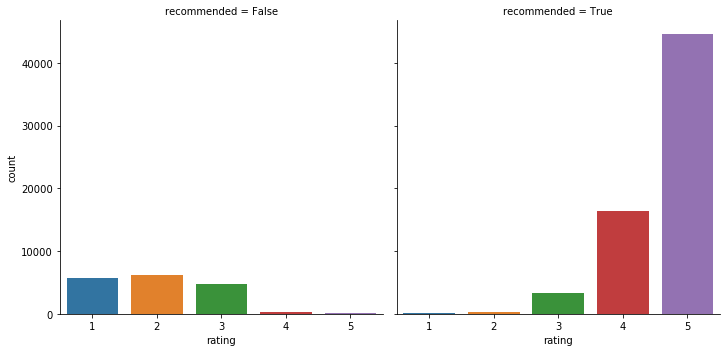

In [112]:
sns.catplot(x = "rating", col = "recommended", data = reviews, kind = "count")

In [113]:
#sns.countplot(reviews[reviews["recommended"] == False]["rating"])

In [114]:
#sns.countplot(reviews[reviews["recommended"] == True]["rating"])

In [115]:
reviews[reviews["recommended"] == False]

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,SPF,user_name,rating,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url,clean_review_text,polarity,subjectivity
22,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Andrea0076,2,False,combination,brown,fair,acne,NaN,NaN,34.0,2018-11-02 16:53:33,2018-12-05 10:56:56,NaN,NaN,"I wanted to love this so much, since I had tri...",/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[wanted, love, much, since, tried, years, find...",0.202222,0.677778
27,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Marianny24,3,False,dry,brown,light,acne,NaN,NaN,34.0,2017-09-13 19:35:46,2018-12-06 11:28:46,NaN,NaN,Absolutely upset that this didn't work for me....,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[absolutely, upset, didnt, work, love, rihanna...",0.202278,0.616722
43,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,DominiqueCox,2,False,combination,NaN,tan,NaN,NaN,NaN,34.0,2018-05-12 03:05:14,2018-11-19 02:04:40,NaN,NaN,This foundation looks great when first applied...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[foundation, looks, great, first, applied, lit...",0.153333,0.577500
57,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,anna2006,1,False,oily,brown,medium,acne,NaN,NaN,34.0,2017-12-19 20:21:11,2018-11-29 21:28:12,NaN,NaN,I honestly don’t understand how people make th...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[honestly, dont, understand, people, make, wor...",0.115780,0.461996
59,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,hannahbraith,1,False,combination,hazel,light,acne,NaN,NaN,34.0,2017-12-22 05:34:25,2018-11-26 19:41:48,NaN,NaN,I want to really love this foundation. The col...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[want, really, love, foundation, colour, match...",0.200000,0.280000
60,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Luciaebeck,1,False,combination,blue,light,acne,NaN,NaN,34.0,2018-01-28 19:24:03,2018-11-16 01:48:55,NaN,NaN,I went to the store very excited to try this f...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[went, store, excited, try, foundation, applie...",0.206250,0.512500
69,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,Kelliet27,1,False,combination,blue,porcelain,NaN,25to34,NaN,34.0,2018-04-09 01:25:09,2018-11-22 08:15:18,NaN,NaN,"I was not a fan, horrible on dry skin. Clings ...",/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[fan, horrible, dry, skin, clings, patches, li...",-0.533333,0.800000
74,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432,Medium,Matte,Liquid,True,True,True,True,False,lovelyladylocs,3,False,oily,brown,dark,cuticles,45to54,NaN,34.0,2017-09-30 00:47:23,2017-09-30 01:00:03,NaN,NaN,I have oily skin and my skin doesn't of the da...,/contentimages/brands/fentybeauty/logo.jpg,https://www.sephora.com/productimages/sku/s192...,"[oily, skin, skin, doesnt, day, even, blotting...",0.243750,0.608333
87,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,P87985432

In [117]:
reviews["first_submission_date"].head()

0    2018-01-06 01:04:26
1    2018-10-19 00:29:37
2    2018-02-05 21:40:40
3    2018-05-09 00:32:04
4    2018-12-03 00:40:58
Name: first_submission_date, dtype: object

In [118]:
reviews["last_submission_date"].head()

0    2018-12-08 05:44:51
1    2018-12-07 15:16:13
2    2018-12-08 19:07:33
3    2018-12-03 09:54:03
4    2018-12-06 02:32:21
Name: last_submission_date, dtype: object

<a id = "conclusions"></a>

## Conclusions

- Average overall rating is
- Top 10 cities: New York, LA, Chicago, San Francisco, Boston, Houston, Seattle, San Diego, Toronto, Washington DC
- There are 217 distinct foundations from 63 different brands, with 14 products coming from Clinique.
- Foundation prices range from \\$18 (Sephora brand) to \\$120 (La Mer and Giorgio Armani), and have an average price of \\$44.71 and median price of \\$42.
- Average rating increases with age


- Ratings decrease with higher Sephora tiers


- Incentivized ratings are higher than non-incentivized ratings on average (not surprising)


In [116]:
tags.groupby(["Value"]).agg({"Count": "sum"}).sort_values(by = "Count", ascending = False)

NameError: name 'tags' is not defined

In [ ]:
tags = pd.read_csv("./data/Sephora_Foundation_Tags.csv")

In [ ]:
tags

In [ ]:
tags.groupby(["brand", "product"]).size()

In [ ]:
#tags["Value"].value_counts().hist()

In [ ]:
#tags.groupby(["brand"]).agg({"Value": lambda x:x.value_counts()[0]})

In [ ]:
#tags[["brand", "product"]]